_Neural Data Science_

Lecturer: Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Rita González Márquez, Fabio Seel

Summer term 2024

Student names: Artemii Shlychkov, Elizabeth Seiffert, Arne Gittel

# Coding Lab 2

- __Data__: Use the saved data `nds_cl_1_*.npy` from Coding Lab 1. Or, if needed, download the data files ```nds_cl_1_*.npy``` from ILIAS and save it in the subfolder ```../data/```.
- __Dependencies__: You don't have to use the exact versions of all the dependencies in this notebook, as long as they are new enough. But if you run "Run All" in Jupyter and the boilerplate code breaks, you probably need to upgrade them.

In [61]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from __future__ import annotations
import matplotlib
import scipy.stats as stats
from scipy.stats import multivariate_normal
import scipy as sp

# import lda from sklearn
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.mixture import GaussianMixture

%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2024-05-12 21:31:49Mitteleuropäische Sommerzeit

Python implementation: CPython
Python version       : 3.10.0
IPython version      : 8.24.0

sklearn: 1.4.2

matplotlib: 3.8.4
scipy     : 1.13.0
numpy     : 1.26.4

Watermark: 2.4.3



In [62]:
plt.style.use("../matplotlib_style.txt")

## Load data

In [63]:
# replace by path to your solutions
features = np.load("../data/nds_cl_1_features.npy")
s = np.load("../data/nds_cl_1_spiketimes_s.npy")
w = np.load("../data/nds_cl_1_waveforms.npy")
np.random.seed(0)

## Task 1: Generate toy data

Sample 1000 data points from a two dimensional mixture of Gaussian model with three clusters  and the following parameters:

$\mu_1 = \begin{bmatrix}0\\0\end{bmatrix}, \Sigma_1 = \begin{bmatrix}1 & 0\\0 & 1\end{bmatrix}, \pi_1=0.3$

$\mu_2 = \begin{bmatrix}5\\1\end{bmatrix}, \Sigma_2 = \begin{bmatrix}2 & 1\\1 & 2\end{bmatrix}, \pi_2=0.5$

$\mu_3 = \begin{bmatrix}0\\4\end{bmatrix}, \Sigma_3 = \begin{bmatrix}1 & -0.5\\-0.5 & 1\end{bmatrix}, \pi_3=0.2$

Plot the sampled data points and indicate in color the cluster each point came from. Plot the cluster means as well.

*Grading: 1 pts*


In [64]:
def sample_data(
    n_samples: int,
    means: np.ndarray,
    covariances: np.ndarray,
    priors: np.ndarray,
    random_seed: int = 2046,
) -> tuple[np.ndarray, np.ndarray]:
    """Generate n_samples samples from a Mixture of Gaussian distribution with
    means m, covariances S and priors p.

    Parameters
    ----------

    n_samples: int
        Number of samples

    m: np.ndarray, (n_clusters, n_dims)
        Means

    S: np.ndarray, (n_clusters, n_dims, n_dims)
        Covariances

    p: np.ndarray, (n_clusters, )
        Cluster weights / probablities

    random_seed: int
        Random Seed

    Returns
    -------

    labels: np.array, (n_samples, )
        Grund truth labels.

    x: np.array, (n_samples, n_dims)
        Data points
    """
    # ensure reproducibility using a random number generator
    # hint: access random functions of this generator
    rng = np.random.default_rng(random_seed)

    # insert your code here
    cluster_ids = np.random.choice(
        [0, 1, 2], n_samples, p=priors
    )  # return a vector of N cluster ids sampled from the given priors
    data = np.array(
        [
            np.random.multivariate_normal(mean=means[id], cov=covariances[id])
            for id in cluster_ids
        ]
    )  # create a data point for each entry of the cluster_ids vector by sampling from the multivariate normal distribution with the means and covariances correcponding to the cluster_ids

    return data, cluster_ids

In [65]:
N = 1000  # total number of samples

priors = np.array([0.3, 0.5, 0.2])  # percentage of each cluster
means = np.array([[0.0, 0.0], [5.0, 1.0], [0.0, 4.0]])  # means
g_means = np.array([[0.0, 0.0], [5.0, 1.0], [0.0, 4.0]])

S1 = np.array([[1.0, 0.0], [0.0, 1.0]])
S2 = np.array([[2.0, 1.0], [1.0, 2.0]])
S3 = np.array([[1.0, -0.5], [-0.5, 1.0]])
S = np.stack([S1, S2, S3])  # cov

toy_data, toy_cluster_ids_true = sample_data(N, means, S, priors)

In [66]:
# ----------------------------------------------
# plot points from mixture of Gaussians (0.5 pt)
# ----------------------------------------------


def plot_clustering(data, true_cluster_ids, fit_cluster_ids, true_means, fit_means):
    """
    Plots the (2D) data as scatter plot, with different colors and an extra symbol for the mean per cluster.
    Args:
        data: (N,n_dimensions)-shaped array of data
        cluster_ids: (N,)-shaped array of integers that hold the cluster assignment for each data point
        means : (n_cluster,n_dimensions)-shaped array of mean vectors
        title: string that is added as title

    """

    mosaic = [["True", "MoG"]]
    fig, ax = plt.subplot_mosaic(mosaic=mosaic, figsize=(8, 4), layout="constrained")
    cmap = matplotlib.colormaps["tab10"]
    colors = cmap(np.linspace(0, 1, len(true_means)))

    for i, k in enumerate(mosaic):
        true = k[0]
        fit = k[1]

        ax[true].scatter(x=data[:, 0], y=data[:, 1], c=colors[true_cluster_ids], s=5)
        ax[true].set_title("True clusters")

        for j, mean in enumerate(true_means):
            if j == 0:
                ax[true].scatter(
                    mean[0],
                    mean[1],
                    s=80,
                    c="yellow",
                    marker="*",
                    edgecolor="black",
                    linewidth=1,
                    label="Cluster means",
                )
            else:
                ax[true].scatter(
                    mean[0],
                    mean[1],
                    s=80,
                    c="yellow",
                    marker="*",
                    edgecolor="black",
                    linewidth=1,
                )
        ax[true].legend()
        if fit_cluster_ids is not None:
            ax[fit].scatter(x=data[:, 0], y=data[:, 1], c=colors[fit_cluster_ids], s=5)
            ax[fit].set_title("Predicted clusters")

            for j, mean in enumerate(fit_means):
                if j == 0:
                    ax[fit].scatter(
                        mean[0],
                        mean[1],
                        s=80,
                        c="yellow",
                        marker="*",
                        edgecolor="black",
                        linewidth=1,
                        label="Cluster means",
                    )
                else:
                    ax[fit].scatter(
                        mean[0],
                        mean[1],
                        s=80,
                        c="yellow",
                        marker="*",
                        edgecolor="black",
                        linewidth=1,
                    )
            ax[fit].legend()
        else:
            fig.delaxes(ax[fit])

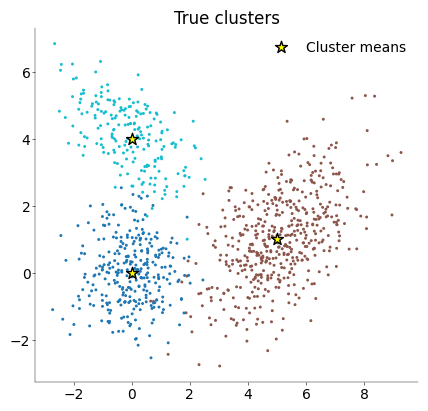

In [67]:
plot_clustering(toy_data, toy_cluster_ids_true, None, means, None)

## Task 2: Implement a Gaussian mixture model

Implement the EM algorithm to fit a Gaussian mixture model in `fit_mog()`.  Sort the data points by inferring their class labels from your mixture model (by using maximum a-posteriori classification). Fix the seed of the random number generator to ensure deterministic and reproducible behavior. Test it on the toy dataset specifying the correct number of clusters and make sure the code works correctly. Plot the data points from the toy dataset and indicate in color the cluster each point was assigned to by your model. How does the assignment compare to ground truth? If you run the algorithm multiple times, you will notice that some solutions provide suboptimal clustering solutions - depending on your initialization strategy.  

*Grading: 4 pts*


It is important to initialize the means, covariances and mixing coefficients appropriately. Also, during optimization, covariance matrices can become singular. To prevent this, one can add a small constant (like $10^{-6}$) to the diagonal.

In [68]:
def initialize_clusters(data, n_clusters):
    """Function that initializes the means and covariances for the EM algorithm
    Args:
        data: (N,n_dimensions)-shaped array of data
        n_clusters: number of clusters
    Returns:
        means: (n_cluster,n_dimensions)-shaped array of mean vectors
        covariances: (n_dimensions,n_dimensions,n_cluster)-shaped array of covariance matrices
        priors: (n_cluster)-shaped arrays of priors / mixing coefficients
    """
    clusters = []
    k_means = KMeans(n_clusters).fit(data)
    mu_k = k_means.cluster_centers_

    # initialize a dictionary containing means, covariances and probabilities for each cluster
    for i in range(n_clusters):
        clusters.append(
            {
                # the initial weight (or probability) of each cluster.
                "pi_k": 1.0 / n_clusters,
                # corresponding mean from the mu_k array obtained from KMeans
                "mu_k": mu_k[i],
                # the initial covariance matrix of each cluster.
                "cov_k": np.cov(data, rowvar=False),
            }
        )

    return clusters

E - step

In [69]:
def expectation_step(data, clusters):
    """Function that performs the E-step of the EM algorithm
    Args:
        data: (N,n_dimensions)-shaped array of data
        clusters: list of dictionaries, each containing the parameters for a cluster
    Returns:
        expectation: N,n_clusters)-shaped array of expected cluster assignments
        totals: (N,1)-shaped array of total probabilities
    """

    N = data.shape[0]  # number of data points
    K = len(clusters)  # number of clusters
    totals = np.zeros((N, 1), dtype=np.float64)  # initialize totals array
    # initialize expectation array
    expectation = np.zeros((N, K), dtype=np.float64)

    for k, cluster in enumerate(clusters):
        pi_k = cluster["pi_k"]
        mu_k = cluster["mu_k"]
        cov_k = cluster["cov_k"]

        # add a small value to the diagonal of the covariance matrix to avoid singular matrices
        cov_k += 1e-6 * np.identity(data.shape[1], dtype=np.float64)

        expectation[:, k] = pi_k * (
            stats.multivariate_normal(mean=mu_k, cov=cov_k).pdf(data)
        )

    totals = np.sum(expectation, 1) 

    expectation /= np.expand_dims(totals, 1)
    return expectation

M - step

In [70]:
def maximization_step(data, clusters):
    """Function that performs the M-step of the EM algorithm
    Args:
        data: (N,n_dimensions)-shaped array of data
        clusters: list of dictionaries, each containing the parameters for a cluster
    Returns:
        updated cluster parameters
    """

    expectation = expectation_step(data, clusters)

    N = float(data.shape[0])  # number of data points

    for k, cluster in enumerate(clusters):

        # Extract the expectation values for cluster k
        expectation_k = expectation[:, k]

        # Calculate N_k (total responsibility for cluster k)
        N_k = np.sum(expectation_k)

        # Update cluster parameters
        pi_k = N_k / N
        mu_k = np.sum(expectation_k.reshape(-1, 1) * data, axis=0) / N_k
        cov_k = (expectation_k.reshape(-1, 1) * (data - mu_k)).T @ (data - mu_k) / N_k

        # Update cluster parameters in the cluster dictionary
        cluster["pi_k"] = pi_k
        cluster["mu_k"] = mu_k
        cluster["cov_k"] = cov_k

Combining the E-step and the M-step together

In [71]:
def fit_mog(
    data: np.ndarray, n_clusters: int, n_iters: int = 10, random_seed: int = 2046
) -> tuple[np.ndarray]:
    """Fit Mixture of Gaussian model using EM algo.

    Parameters
    ----------

    data: np.array, (n_samples, n_dims)
        Input data

    n_clusters: int
        Number of clusters

    n_iters: int
        Maximal number of iterations.

    random_seed: int
        Random Seed


    Returns
    -------

    labels: np.array, (n_samples)
        Cluster labels

    m: list or np.array, (n_clusters, n_dims)
        Means

    S: list or np.array, (n_clusters, n_dims, n_dims)
        Covariances

    p: list or np.array, (n_clusters, )
        Cluster weights / probablities
    """

    # ensure reproducibility using a random number generator
    rng = np.random.default_rng(random_seed)

    # fill in your code here

    # -----------
    # init (1 pt)
    # -----------
    clusters = initialize_clusters(data, n_clusters)  # initialize clusters
    scores = np.zeros((data.shape[0], n_clusters))  # initialize scores array

    # -------------------------
    # EM maximisation (2.5 pts)
    # -------------------------

    for step in range(n_iters):

        expectation_step(data, clusters)  # E-step
        maximization_step(data, clusters)  # M-step

    expectation = expectation_step(data, clusters)
    scores = np.log(expectation)

    # extract the means from the cluster dictionary
    cluster_means = np.array([cluster["mu_k"] for cluster in clusters])
    # assign each data point to the cluster with the highest score
    cluster_ids = np.argmax(scores, axis=1)

    covariances = np.array([cluster["cov_k"] for cluster in clusters])
    priors = np.array([cluster["pi_k"] for cluster in clusters])
    return cluster_ids, cluster_means, covariances, priors

Run Mixture of Gaussian on toy data

In [72]:
toy_cluster_ids_fit, toy_means_fit, covariances, priors = fit_mog(toy_data, 3)
print(toy_means_fit.shape)

(3, 2)


Plot toy data with cluster assignments and compare to original labels

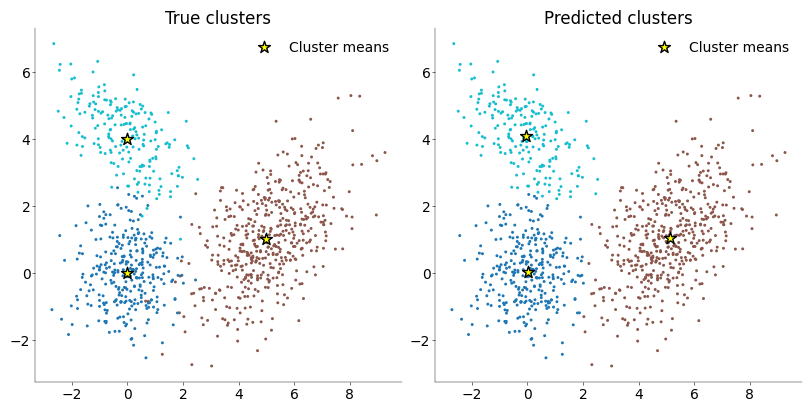

In [73]:
plot_clustering(
    toy_data,
    toy_cluster_ids_true,
    toy_cluster_ids_fit,
    means,
    toy_means_fit,
)

# -----------------
# Add plot (0.5 pts)
# -----------------

## Task 3: Model complexity
A priori we do not know how many neurons we recorded. Extend your algorithm with an automatic procedure to select the appropriate number of mixture components (clusters). Base your decision on the Bayesian Information Criterion:

$BIC = -2L+P \log N,$

where $L$ is the log-likelihood of the data under the best model, $P$ is the number of parameters of the model and $N$ is the number of data points. You want to minimize the quantity. Plot the BIC as a function of mixture components. What is the optimal number of clusters on the toy dataset?

You can also use the BIC to make your algorithm robust against suboptimal solutions due to local minima. Start the algorithm multiple times and pick the best solutions for extra points. You will notice that this depends a lot on which initialization strategy you use.

*Grading: 3 pts*



In [74]:
def mog_bic(
    x: np.ndarray, m: np.ndarray, S: np.ndarray, p: np.ndarray
) -> tuple[float, float]:
    """Compute the BIC for a fitted Mixture of Gaussian model

    Parameters
    ----------

    x: np.array, (n_samples, n_dims)
        Input data

    m: np.array, (n_clusters, n_dims)
        Means

    S: np.array, (n_clusters, n_dims, n_dims)
        Covariances

    p: np.array, (n_clusters, )
        Cluster weights / probablities

    Return
    ------

    bic: float
        BIC

    LL: float
        Log Likelihood
    """
    n_clusters = len(m)  # number of clusters
    n_dims = x.shape[1]  # number of dimensions
    n_samples = x.shape[0]  # number of samples

    # LL = data_likelihood  # log likelihood of the data given the model

    # Calculate the log likelihood of the data given the model
    expectation = np.zeros((n_samples, n_clusters), dtype=np.float64)

    for i, k in enumerate(range(n_clusters)):
        pi_k = p[k]
        mu_k = m[k]
        cov_k = S[k]
        expectation[:, k] = pi_k * stats.multivariate_normal(mean=mu_k, cov=cov_k).pdf(
            x
        )
        totals = np.sum(expectation, 1)
        LL = np.sum(np.log(totals))

    # number of parameters:

    P = (n_clusters - 1) + n_clusters * n_dims + n_clusters * n_dims * (n_dims + 1) / 2

    bic = -2 * LL + P * np.log(n_samples)
    # insert your code here

    # -------------------------
    # implement the BIC (1.5 pts)
    # -------------------------

    return bic, LL

In [75]:
bic, LL = mog_bic(toy_data, toy_means_fit, S, priors)  # compute BIC

Below we will additionally compare our GMM implementation to the scikit learn GMM 

In [76]:
# ---------------------------------------------------------------------------------------------------
# Compute and plot the BIC for mixture models with different numbers of clusters (e.g., 2 - 6). (0.5 pts)
# Make your algorithm robust against local minima. (0.5 pts) and plot the result (0.5 pts)
# ---------------------------------------------------------------------------------------------------

possible_clusters = range(2, 7)
num_seeds = 10

BIC = np.zeros((num_seeds, len(possible_clusters)))
LL = np.zeros((num_seeds, len(possible_clusters)))
sklearn_BIC = np.zeros((num_seeds, len(possible_clusters)))
sklearn_LL = np.zeros((num_seeds, len(possible_clusters)))

# Running manual GMM
for i, k in enumerate(possible_clusters):
    for j in range(num_seeds):
        (cluster_ids, means, covariances, priors) = fit_mog(toy_data, k)

        BIC[j, i], LL[j, i] = mog_bic(toy_data, means, covariances, priors)

# Running sklearn GMM
for i, k in enumerate(possible_clusters):
    for j in range(num_seeds):
        sklearn_gmm = GaussianMixture(
            n_components=k, covariance_type="full", init_params="k-means++"
        )
        sklearn_gmm.fit(toy_data)
        sklearn_BIC[j, i], sklearn_LL[j, i] = mog_bic(
            toy_data, sklearn_gmm.means_, sklearn_gmm.covariances_, sklearn_gmm.weights_
        )



In [77]:
# Get the optimal number of clusters for the manual GMM
model_index, cluster_index = np.where(BIC == BIC.min())
optimal_cluster_number = possible_clusters[cluster_index[0]]
lowest_bic = BIC[model_index[0], :]
print(f"Optimal number of clusters: {optimal_cluster_number}")

# Get the optimal number of clusters for the sklearn GMM
sklearn_model_index, sklearn_cluster_index = np.where(sklearn_BIC == sklearn_BIC.min())
sklearn_optimal_cluster_number = possible_clusters[sklearn_cluster_index[0]]
sklearn_lowest_bic = sklearn_BIC[sklearn_model_index[0], :]
print(f"Optimal number of clusters: {sklearn_optimal_cluster_number}")

Optimal number of clusters: 3
Optimal number of clusters: 3


Text(0.5, 1.0, 'BIC for different number of clusters')

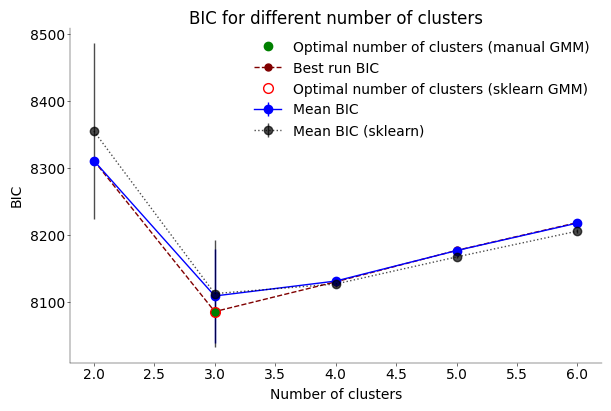

In [78]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.errorbar(
    possible_clusters,
    np.mean(BIC, axis=0),
    yerr=np.std(BIC, axis=0),
    fmt="o-",
    label="Mean BIC",
    color="blue",
)
ax.plot(
    optimal_cluster_number,
    BIC[model_index[0], cluster_index[0]],
    color="green",
    label="Optimal number of clusters (manual GMM)",
    linestyle="",
    marker="o",
    zorder=10,
)
ax.plot(
    possible_clusters,
    lowest_bic,
    color="maroon",
    label="Best run BIC",
    linestyle="--",
    marker="o",
    markersize=5,
)

ax.errorbar(
    possible_clusters,
    np.mean(sklearn_BIC, axis=0),
    yerr=np.std(sklearn_BIC, axis=0),
    fmt="o:",
    label="Mean BIC (sklearn GMM)",
    color="black",
    alpha=0.7,
)

ax.plot(
    sklearn_optimal_cluster_number,
    sklearn_BIC[sklearn_model_index[0], sklearn_cluster_index[0]],
    color="red",
    label="Optimal number of clusters (sklearn GMM)",
    linestyle="",
    marker="o",
    mfc="none",
    markersize=7,
    zorder=10,
)

ax.set_xlabel("Number of clusters")
ax.set_ylabel("BIC")
ax.legend()
ax.set_title("BIC for different number of clusters")

# plot BIC

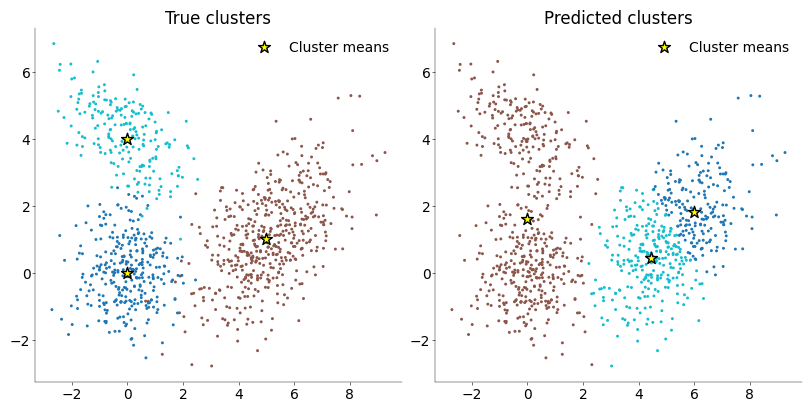

In [79]:
sklearn_gmm = GaussianMixture(
    n_components=sklearn_optimal_cluster_number, covariance_type="full", max_iter=1000
)
sklearn_gmm.fit(toy_data)

plot_clustering(
    toy_data,
    toy_cluster_ids_true,
    sklearn_gmm.predict(toy_data),
    g_means,
    sklearn_gmm.means_,
)

## Task 4: Spike sorting using Mixture of Gaussian 
Run the full algorithm on your set of extracted features (including model complexity selection). Plot the BIC as a function of the number of mixture components on the real data. For the best model, make scatter plots of the first PCs on all four channels (6 plots). Color-code each data point according to its class label in the model with the optimal number of clusters. In addition, indicate the position (mean) of the clusters in your plot. 

*Grading: 3 pts*


In [80]:
# features = np.load("../data/example_features.npy")

In [81]:
# ------------------------------------------------------------------------------------------
# Select the model that best represents the data according to the BIC (include plot) (1 pt)
# ------------------------------------------------------------------------------------------

possible_clusters = np.arange(2, 16)
num_seeds = 5

BIC = np.zeros((num_seeds, len(possible_clusters)))
LL = np.zeros((num_seeds, len(possible_clusters)))
sklearn_BIC = np.zeros((num_seeds, len(possible_clusters)))
sklearn_LL = np.zeros((num_seeds, len(possible_clusters)))

for i, k in enumerate(possible_clusters):
    for j in range(num_seeds):
        cluster_ids, means, covariances, priors = fit_mog(features, k)
        BIC[j, i], LL[j, i] = mog_bic(features, means, covariances, priors)

for i, k in enumerate(possible_clusters):
    for j in range(num_seeds):
        sklearn_gmm = GaussianMixture(
            n_components=k, covariance_type="full", max_iter=1000
        )
        sklearn_gmm.fit(features)
        sklearn_BIC[j, i], sklearn_LL[j, i] = mog_bic(
            features, sklearn_gmm.means_, sklearn_gmm.covariances_, sklearn_gmm.weights_
        )

In [82]:
# Find the optimal number of clusters according to the BIC in all model runs and possible cluster numbers

# Get the optimal number of clusters for the manual GMM
model_index, cluster_index = np.where(BIC == BIC.min())
optimal_cluster_number = possible_clusters[cluster_index[0]]
lowest_bic = BIC[model_index[0], :]
print(f"lowest BIC: # cluster = {optimal_cluster_number}")

# Get the optimal number of clusters for the sklearn GMM
sklearn_model_index, sklearn_cluster_index = np.where(sklearn_BIC == sklearn_BIC.min())
sklearn_optimal_cluster_number = possible_clusters[sklearn_cluster_index[0]]
sklearn_lowest_bic = sklearn_BIC[sklearn_model_index[0], :]
print(f"Optimal number of clusters: {sklearn_optimal_cluster_number}")

lowest BIC: # cluster = 13
Optimal number of clusters: 13


Text(0.5, 1.0, 'BIC for different number of clusters')

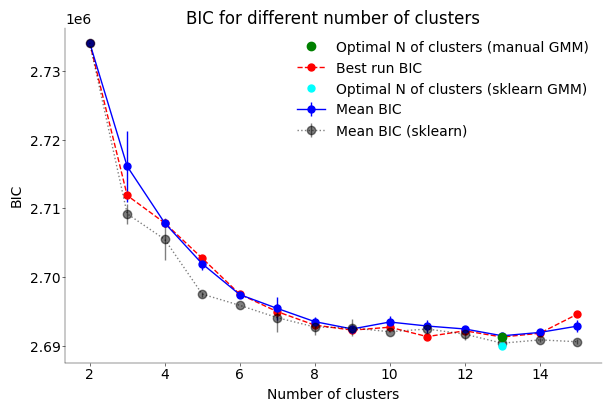

In [83]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.errorbar(
    possible_clusters,
    np.mean(BIC, axis=0),
    yerr=np.std(BIC, axis=0),
    fmt="o-",
    label="Mean BIC",
    color="blue",
    markersize=5,
)

ax.plot(
    optimal_cluster_number,
    BIC[model_index, cluster_index][0],
    color="green",
    label="Optimal N of clusters (manual GMM)",
    marker="o",
    markersize=6,
    zorder=10,
    linestyle="",
)
ax.plot(
    possible_clusters,
    lowest_bic,
    color="red",
    label="Best run BIC",
    linestyle="--",
    marker="o",
    markersize=5,
)

ax.errorbar(
    possible_clusters,
    np.mean(sklearn_BIC, axis=0),
    yerr=np.std(sklearn_BIC, axis=0),
    fmt="o:",
    label="Mean BIC (sklearn GMM)",
    color="black",
    alpha=0.5,
)

ax.plot(
    sklearn_optimal_cluster_number,
    sklearn_BIC[sklearn_model_index[0], sklearn_cluster_index[0]],
    color="cyan",
    label="Optimal N of clusters (sklearn GMM)",
    linestyle="",
    marker="o",
    markersize=5,
    zorder=10,
)

ax.set_xlabel("Number of clusters")
ax.set_ylabel("BIC")
ax.legend()
ax.set_title("BIC for different number of clusters")

Refit model with lowest BIC and plot data points

In [84]:
cluster_ids, means, covariances, priors = fit_mog(
    features, optimal_cluster_number, random_seed=model_index[0]
)  # fit the model with the optimal number of clusters

sklearn_gmm = GaussianMixture(
    n_components=sklearn_optimal_cluster_number, covariance_type="full"
)
sklearn_gmm.fit(features)
# print(sklearn_gmm.predict(features))
# print(cluster_ids)

GaussianMixture(n_components=13)

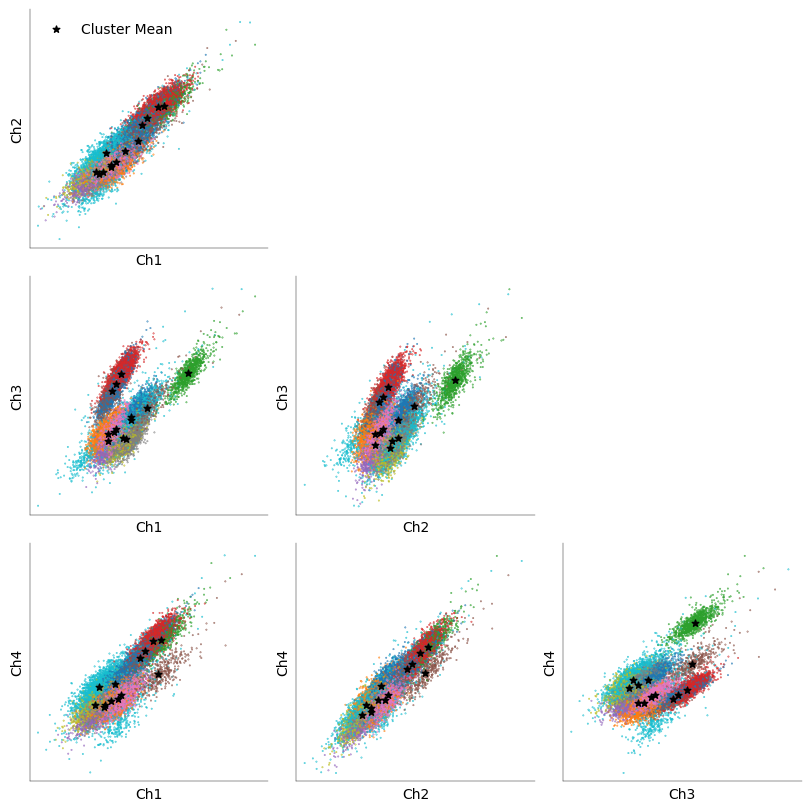

In [85]:
# -------------------------------------------------------------------------------------
# Create scatterplots of the first PCs under the best model for all 4 channels. (2 pts)
# -------------------------------------------------------------------------------------


mosaic = [
    ["Ch2 vs Ch1", ".", "."],
    ["Ch3 vs Ch1", "Ch3 vs Ch2", "."],
    ["Ch4 vs Ch1", "Ch4 vs Ch2", "Ch4 vs Ch3"],
]
fig, ax = plt.subplot_mosaic(mosaic=mosaic, figsize=(8, 8), layout="constrained")

cmap = matplotlib.colormaps["tab10"]
colors = cmap(np.linspace(0, 1, len(means)))

i = {"Ch1": 0, "Ch2": 3, "Ch3": 6, "Ch4": 9}
for m in np.ravel(mosaic):
    if m == ".":
        continue
    y, x = m.split(" vs ")

    a = i[y]
    b = i[x]
    ax[m].scatter(features[:, a], features[:, b], s=0.5, c=colors[cluster_ids])

    # plot means of clusters
    ax[m].scatter(
        means[:, a], means[:, b], s=25, c="black", marker="*", label="Cluster Mean"
    )
    ax["Ch2 vs Ch1"].legend()
    ax[m].set_xlabel(x)
    ax[m].set_ylabel(y)

    x_min, x_max = np.min(features[:, a]), np.max(features[:, a])
    y_min, y_max = np.min(features[:, b]), np.max(features[:, b])

    ax[m].set_xlim(1.1 * x_min, 1.1 * x_max)
    ax[m].set_ylim(1.1 * y_min, 1.1 * y_max)
    ax[m].set_xticks([])
    ax[m].set_yticks([])

[0.12156863 0.46666667 0.70588235 1.        ] [0.12156863 0.46666667 0.70588235 1.        ]


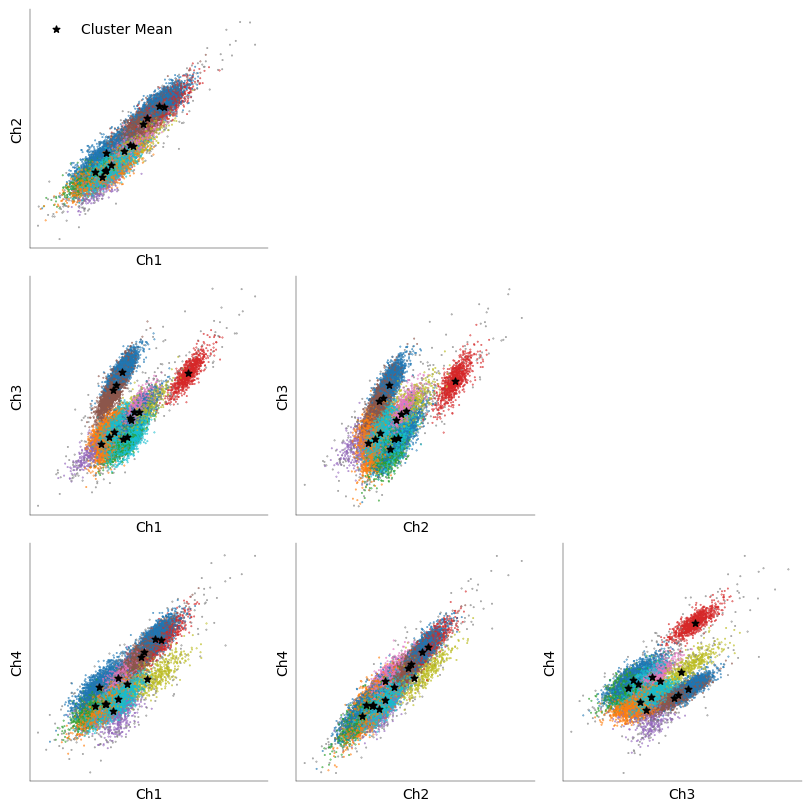

In [86]:
mosaic = [
    ["Ch2 vs Ch1", ".", "."],
    ["Ch3 vs Ch1", "Ch3 vs Ch2", "."],
    ["Ch4 vs Ch1", "Ch4 vs Ch2", "Ch4 vs Ch3"],
]
fig, ax = plt.subplot_mosaic(mosaic=mosaic, figsize=(8, 8), layout="constrained")

cmap = matplotlib.colormaps["tab10"]
colors = cmap(
    np.linspace(
        0,
        1,
        len(
            sklearn_gmm.means_,
        ),
    )
)
print(colors[0], colors[1])

i = {"Ch1": 0, "Ch2": 3, "Ch3": 6, "Ch4": 9}
for m in np.ravel(mosaic):
    if m == ".":
        continue
    y, x = m.split(" vs ")

    a = i[y]
    b = i[x]
    ax[m].scatter(
        features[:, a],
        features[:, b],
        s=0.5,
        c=colors[sklearn_gmm.predict(features)],
    )

    # plot means of clusters
    ax[m].scatter(
        sklearn_gmm.means_[:, a],
        sklearn_gmm.means_[:, b],
        s=25,
        c="black",
        marker="*",
        label="Cluster Mean",
    )
    ax["Ch2 vs Ch1"].legend()
    ax[m].set_xlabel(x)
    ax[m].set_ylabel(y)

    x_min, x_max = np.min(features[:, a]), np.max(features[:, a])
    y_min, y_max = np.min(features[:, b]), np.max(features[:, b])

    ax[m].set_xlim(1.1 * x_min, 1.1 * x_max)
    ax[m].set_ylim(1.1 * y_min, 1.1 * y_max)
    ax[m].set_xticks([])
    ax[m].set_yticks([])

### Task 5: Cluster separation

Implement linear discriminant analysis to visualize how well each cluster is separated from its neighbors in the high-dimensional space in the function `separation()`. Project the spikes of each pair of clusters onto the axis that optimally separates those two clusters. 

Plot a matrix with pairwise separation plots, showing the histogram of the points in both clusters projected on the axis best separating the clusters (as shown in the lecture). *Hint:* Since Python 3.5+, matrix multiplications can be compactely written as `x@y`.

*Grading: 4 pts*


In [98]:
def separation(
    b: np.ndarray,
    m: np.ndarray,
    S: np.ndarray,
    assignment: np.ndarray,
    n_bins: int = 50,
):
    """Calculate cluster separation by LDA.

    proj, bins = separation(b, m, S, p, assignment)
    projects the data on the LDA axis for all pairs of clusters. The result
    is normalized such that the left (i.e. first) cluster has
    zero mean and unit variances. The LDA axis is estimated from the model.
    ---

    Parameters
    ----------
    b: np.array, (n_spikes, n_features)
        Features.

    m: np.array, (n_clusters, n_features)
        Means.

    S: np.array, (n_clusters, n_features, n_features)
        Covariance.

    assignment: np.array, (n_spikes, )
        Cluster assignments / labels for each spike

    n_bins: int
        Number of bins in a lda histogram.


    Returns
    -------

    proj: np.array, (n_bins, n_clusters, n_clusters)
        computed lda histo# Comparing the cells in particular

    bins: np.array, (n_bins)
        bin times relative to center    #bins x 1
    """

    n_clusters = len(m)
    n_features = b.shape[1]

    # initialize the lda object
    lda = LDA()

    lda_results_list = []
    # lda_results_array = np.zeros((n_bins, n_clusters, n_clusters))

    for i in range(n_clusters):
        for j in range(n_clusters):
            if i == j:
                lda_results_list.append(None)
                continue
            cluster_1 = b[assignment == i] # get the data points corresponding to the first cluster
            cluster_2 = b[assignment == j] # get the data points corresponding to the second cluster
            data_matrix = np.vstack([cluster_1, cluster_2]) # stack the data points of the two clusters
            labels = np.hstack([np.zeros(len(cluster_1)), np.ones(len(cluster_2))]) # create a label vector for the two clusters
            lda.fit(data_matrix, labels) # fit the lda model to the data
            cluster_1_proj = lda.transform(cluster_1) # project the data points of the first cluster
            cluster_2_proj = lda.transform(cluster_2) # project the data points of the second cluster

            # normalize the data
            cluster_1_proj_mean = np.mean(cluster_1_proj)
            cluster_1_proj_std = np.std(cluster_1_proj)
            cluster_1_proj_normalized = (
                cluster_1_proj - cluster_1_proj_mean
            ) / cluster_1_proj_std

            # Normalize the second cluster using the same parameters
            cluster_2_proj_normalized = (
                cluster_2_proj - cluster_1_proj_mean
            ) / cluster_1_proj_std

            # add label to the current cluster
            label_cluster_1 = np.full_like(cluster_1_proj_normalized, i)
            label_cluster_2 = np.full_like(cluster_2_proj_normalized, j)

            cluster_1_proj_normalized = np.hstack(
                [cluster_1_proj_normalized, label_cluster_1]
            ) # add the labels to the projected data

            cluster_2_proj_normalized = np.hstack(
                [cluster_2_proj_normalized, label_cluster_2]
            ) # add the labels to the projected data

            lda_results_list.append(
                (cluster_1_proj_normalized, cluster_2_proj_normalized)
            ) # append the projected data to the lda_results_list

    return lda_results_list

In [99]:
lda_results_list = separation(features, means, covariances, cluster_ids) # compute lda

In [96]:
print(len(lda_results_list))

156


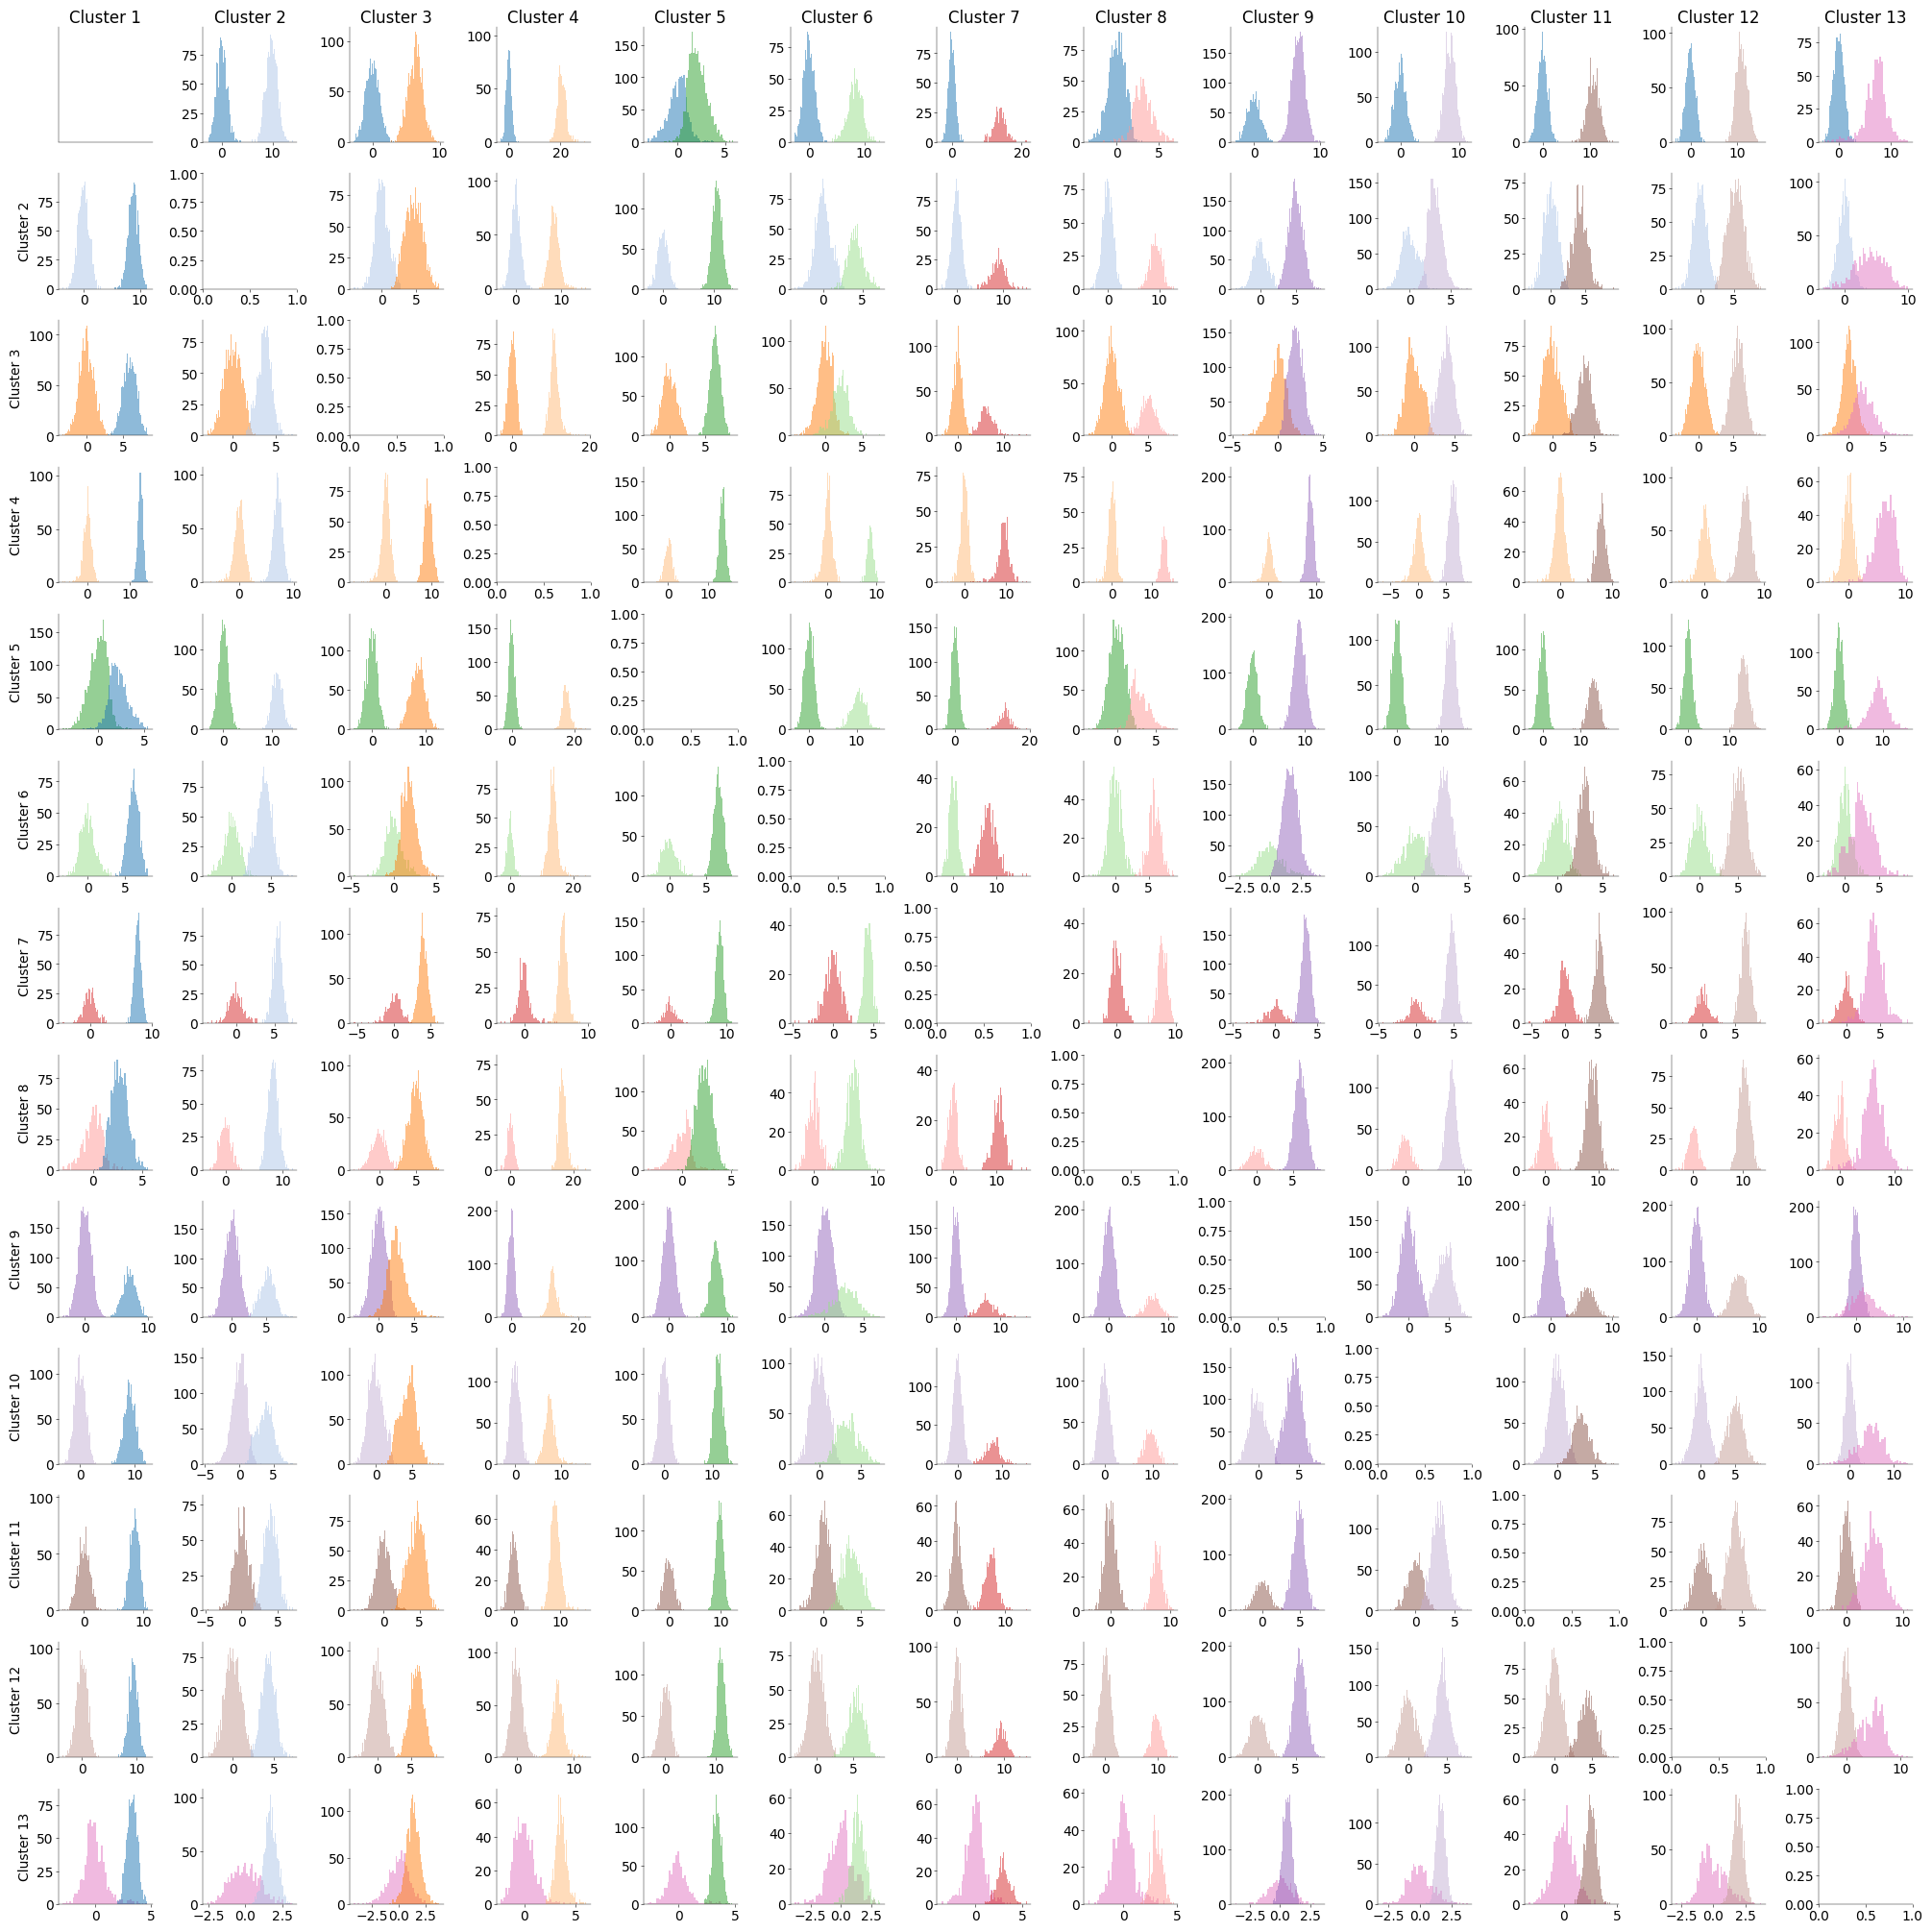

In [103]:
fig, ax = plt.subplots(13, 13, figsize=(20, 20))
cmap = matplotlib.colormaps["tab20"]
for i in range(13):
    for j in range(13):
        if i == j:
            # plt.delaxes(ax[i, j])
            # ax[i, j].axis("off")
            if i == 0 and j == 0:
                ax[i, j].set_ylabel("Cluster 1")
                ax[i, j].yaxis.label.set_visible(True)
                ax[i, j].yaxis.set_visible(False)

                ax[i, j].set_title("Cluster 1")
                ax[i, j].xaxis.set_visible(False)

            continue

        ax[i, j].hist(
            lda_results_list[i * 13 + j][0][:, 0],
            bins=50,
            alpha=0.5,
            label=f"Cluster {int(lda_results_list[i * 13 + j][0][0, 1])}",
            color=cmap(i), 
        )
        ax[i, j].hist(
            lda_results_list[i * 13 + j][1][:, 0],
            bins=50,
            alpha=0.5,
            label=f"Cluster {int(lda_results_list[i * 13 + j][1][0, 1])}",
            color=cmap(j),
        )
        # ax[i, j].legend()
        if i == 0:
            ax[i, j].set_title(f"Cluster {j+1}")
        if j == 0:
            ax[i, j].set_ylabel(f"Cluster {i+1}")